# Kernel Derivatives: Regularization

In [1]:
import numpy as np

from time import time
import warnings

from scipy.spatial.distance import pdist

from sklearn.metrics import (make_scorer, mean_squared_error,
                             mean_absolute_error)
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (GridSearchCV, learning_curve, 
                                     validation_curve, StratifiedShuffleSplit,
                                     KFold, train_test_split)
import scipy as scio
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.linear_model.ridge import _solve_cholesky_kernel as chol_solver
from matplotlib import pyplot as plt
from matplotlib import ticker
%matplotlib inline

from rbf_derivative_cy import rbf_derivative as rbf_derivative_cy
from krr import KRR, rbf_derivative

In [2]:
# set the seed to zero for reproducibility
seed = 123
np.random.seed(seed)

x = {}
y = {}

# ----------------------------------
# GENERATE SIGNAL
# ----------------------------------

# generate an x signal between 0 and 20.
num_data = 1000
x['data'] = np.linspace(0, 3*np.pi, num=num_data)[:, np.newaxis]       # generate points between 0 and 20

# signal function (analytical)
def f(x, scaling=0.1, n_derivative=0):
    
    # 0th derivative
    if n_derivative is 0:
        
        value =  np.sin(2 * np.pi * scaling * x)
    
    # 1st derivative
    elif n_derivative is 1:
        
        value = (2 * np.pi * scaling) * np.cos(2 * np.pi * scaling * x)
    
    # 2nd derivative
    elif n_derivative is 2:
        
        value = -(2 * np.pi * scaling)**2 * np.sin(2 * np.pi * scaling * x)
    
    else:
        raise ValueError('Value needs to be between 0 and 1.')
        
    return value

def get_derivative(func, x):
    h = 0.0001
    return (func(x + h) - func(x)) / h

x['signal'] = f(x['data'])                   # 2 + sin(x)
x['signal'] = x['signal']/x['signal'].max()  # normalize
std_signal = np.std(x['signal'])          



print('Standard Deviation, Signal: {:.3f}\n'.format(std_signal))

# ----------------------------------
# GENERATE NOISE
# ----------------------------------

# generate a noise sample with a sc
std_noise = 0.1    # scale parameter of 0.1

print('Standard Deviation, Noise: {:.3f}\n'.format(std_noise))

snr = 20 * np.log(np.std(x['data'])/std_noise)

print('Signal-to-Noise Ratio (SNR): {:.3f}\n'.format(snr))

size = np.shape(x['data'])

x['noise'] = np.random.normal(scale=std_noise, size=size)

# ----------------------------------
# GENERATE DATA
# ----------------------------------

y['data'] = x['signal'] + x['noise']

#
# ANALYTICAL DERIVATIVES
# 

# -------------------------------
# TRAINING TESTING SPLIT
# ------------------------------
train_percentage = 0.7
validation_percentage = 0.2

x['train'], x['test'], y['train'], y['test'] = \
    train_test_split(x['data'], y['data'], train_size=train_percentage,
                     random_state=seed)
    
x['train'], x['validation'], y['train'], y['validation'] = \
    train_test_split(x['train'], y['train'], train_size=1.0-validation_percentage,
                     random_state=seed)
    
print('Shape of training: {}'.format(np.shape(x['train'])))
print('Shape of validation: {}'.format(np.shape(x['validation'])))
print('Shape of testing: {}'.format(np.shape(x['test'])))

Standard Deviation, Signal: 0.726

Standard Deviation, Noise: 0.100

Signal-to-Noise Ratio (SNR): 66.089

Shape of training: (560, 1)
Shape of validation: (140, 1)
Shape of testing: (300, 1)


/Users/eman/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### KRR ($||w||$)

In [3]:
# parameter heuristics
mean_sigma = np.mean(pdist(x['train'], metric='euclidean'))
lam = 0.01


# construct kernel matrices
K_train = rbf_kernel(X=x['train'], gamma=mean_sigma)
K_test = rbf_kernel(X=x['train'], Y=x['test'], gamma=mean_sigma)

# fast method: cholesky decomposition manually
t0 = time()
R = cholesky(K_train + lam * np.eye(x['train'].shape[0]))
alpha = scio.linalg.solve(R, scio.linalg.solve(R.T, y['train']))
t1 = time() - t0

# project the data
y_pred = np.matmul(K_test.T, alpha)

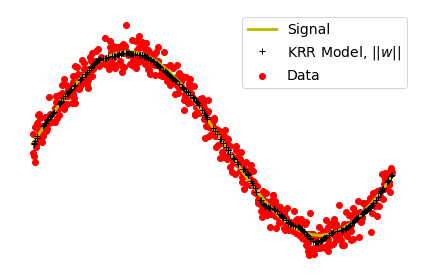

In [4]:
fig, ax = plt.subplots()

# plot the signal
ax.plot(x['data'], x['signal'], color='y', linewidth=3, label='Signal')

# plot kernel model
ax.plot(x['test'], y_pred, 'k+', linewidth=3, label=r'KRR Model, $||w||$')

# plot data
ax.scatter(x['train'], y['train'], color='r', label='Data')

ax.tick_params(
    axis='both',
    which='both',
    bottom='off',
    left='off',
    top='off',
    labelbottom='off',
    labelleft='off')

# get rid of frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.legend(fontsize=14)
plt.tight_layout()

plt.show()

### With Cross Validation

In [5]:
# initialize the parameter candidates
sigma_candidates = np.logspace(-3, 3, num=20)
lam_candidates = np.hstack((np.logspace(-10, 10, num=20)))

# initialize grid
score_grid = np.empty(shape=(len(sigma_candidates), len(lam_candidates)))

print('Shape of grid: {}'.format(score_grid.shape))
print('Number of sigmas: {}'.format(score_grid.shape[0]))
print('Number of lambdas: {}'.format(score_grid.shape[1]))
min_score = np.inf

# loop through sigma values
for (i, isigma) in enumerate(sigma_candidates):
    
    # loop through lambda values
    for (j, ilam) in enumerate(lam_candidates):
        
        igamma = 1 / (2 * isigma ** 2)
        
        # construct kernel matrices
        K_train = rbf_kernel(X=x['train'], gamma=igamma)
        K_test = rbf_kernel(X=x['train'], Y=x['validation'], gamma=igamma)

        # fast method: cholesky decomposition manually
        R = cholesky(K_train + ilam * np.eye(x['train'].shape[0]))
        alpha = scio.linalg.solve(R, scio.linalg.solve(R.T, y['train']))

        # project the data
        y_pred = (K_test.T @ alpha).squeeze()
        
        # save the score
        score_grid[i, j] = mean_absolute_error(y['validation'], y_pred)
        
        # save best score
        if score_grid[i, j] < min_score:
            
            min_score = score_grid[i, j]
            best_lam_idx = j
            best_sigma_idx = i
            best_lam = ilam
            best_sigma = isigma
       

# normalize score grid
score_grid = score_grid

print('Minimum Score: {}'.format(min_score))
print('Best Lambda: {}'.format(best_lam))
print('Best Sigma: {}'.format(best_sigma))
print('Best Lambda Index: {}'.format(best_lam_idx))
print('Best Sigma Index: {}'.format(best_sigma_idx))

Shape of grid: (20, 20)
Number of sigmas: 20
Number of lambdas: 20
Minimum Score: 0.08274433455358615
Best Lambda: 0.2976351441631313
Best Sigma: 1.438449888287663
Best Lambda Index: 9
Best Sigma Index: 10


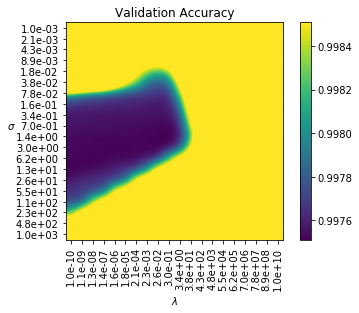

In [6]:
# initialize the parameter candidates
fig, ax = plt.subplots()

# plot the colormap
aux_score_grid = score_grid**0.001
cax = ax.imshow(aux_score_grid, interpolation='bicubic', 
                origin='upper',
                vmin = aux_score_grid.min(), vmax = aux_score_grid.min()*1.001)

# # plot the minimum values
# plt.plot(best_sigma_idx, best_lam_idx,
#          color='red', marker='+', markersize=15)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

# def format_ticks(value, tick_number):
    

fmt_sigma = ['%1.1e' % i for i in sigma_candidates.tolist()]
fmt_lam = ['%1.1e' % i for i in lam_candidates.tolist()]

ax.set_xlabel(r'$\lambda$')
ax.set_xticks(np.arange(len(fmt_lam)))
ax.set_xticklabels(fmt_lam, rotation=90)

ax.set_ylabel(r'$\sigma$', rotation=0)
ax.set_yticks(np.arange(len(fmt_sigma)))
ax.set_yticklabels(fmt_sigma)

cbar = fig.colorbar(cax)
ax.set_title('Validation Accuracy')
plt.show()

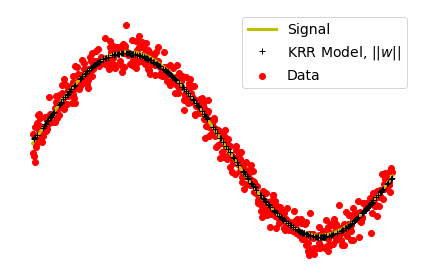

In [7]:
best_gamma = 1 / (2 * best_sigma ** 2)

# construct kernel matrices
K_train = rbf_kernel(X=x['train'], gamma=best_gamma)
K_test = rbf_kernel(X=x['train'], Y=x['test'], gamma=best_gamma)

# fast method: cholesky decomposition manually
R = cholesky(K_train + best_lam * np.eye(x['train'].shape[0]))
alpha = scio.linalg.solve(R, scio.linalg.solve(R.T, y['train']))

# project the data
y_pred = (K_test.T @ alpha).squeeze()
fig, ax = plt.subplots()

# plot the signal
ax.plot(x['data'], x['signal'], color='y', linewidth=3, label='Signal')

# plot kernel model
ax.plot(x['test'], y_pred, 'k+', linewidth=3, label=r'KRR Model, $||w||$')

# plot data
ax.scatter(x['train'], y['train'], color='r', label='Data')

ax.tick_params(
    axis='both',
    which='both',
    bottom='off',
    left='off',
    top='off',
    labelbottom='off',
    labelleft='off')

# get rid of frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.legend(fontsize=14)
plt.tight_layout()

plt.show()

## Kernel Ridge Regression ($\partial f$)

In [8]:
# parameter heuristics
mean_sigma = np.mean(pdist(x['train'], metric='euclidean'))
mean_gamma = 1 / (2 * mean_sigma ** 2)
lam = 1.0


# construct kernel matrices
K_train = rbf_kernel(X=x['train'], gamma=mean_sigma)
K_test = rbf_kernel(X=x['train'], Y=x['test'], gamma=mean_sigma)

# construct derivative
x_train = np.float64(x['train'])
x_function = np.float64(x['train'])
kernel_mat = np.float64(K_train)
temp_weights = np.float64(np.ones(x_train.shape[0])).squeeze()
mean_gamma = np.float64(mean_gamma)
n_derivative = 1

# Python Implementation
t0 = time()
derivative = rbf_derivative(x_train=x_train,
                               x_function=x_function,
                               kernel_mat=kernel_mat,
                               weights=temp_weights,
                               gamma=mean_gamma,
                               n_derivative=n_derivative)
t1_python = time() - t0
print('Time taken for Python: {:.4f} secs'.format(t1_python))

# Cython Implementation
t0 = time()
derivative_cy = rbf_derivative_cy(x_train=x_train,
                               x_function=x_function,
                               kernel_mat=kernel_mat,
                               weights=temp_weights,
                               gamma=mean_gamma,
                               n_derivative=n_derivative)
t1_cython = time() - t0
print('Time taken for Cython: {:.4f} secs'.format(t1_cython))

# slow method: solve problem
t0 = time()
alpha = scio.linalg.solve(K_train @ K_train + 
                          lam * derivative_cy @ derivative_cy.T, 
                          K_train.T @ y['train'])
t1 = time() - t0
print('Time taken for solve: {}'.format(t1))


print('\nSpeedup: x{:.2f}'.format(t1_python/t1_cython))
print('\nAll values are the same:',
      np.allclose(derivative, derivative_cy))

# project the data
y_pred = np.matmul(K_test.T, alpha)

Time taken for Python: 0.4524 secs
Time taken for Cython: 0.0219 secs
Time taken for solve: 0.03361988067626953

Speedup: x20.70

All values are the same: True


/Users/eman/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.2794810263175804e-21 / 1.1102230246251565e-16
  RuntimeWarning)


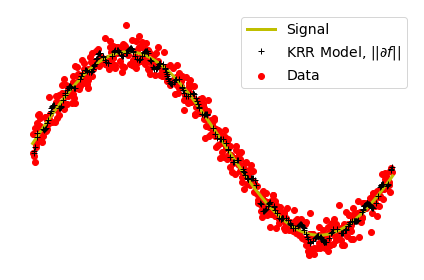

In [9]:
fig, ax = plt.subplots()

# plot the signal
ax.plot(x['data'], x['signal'], color='y', linewidth=3, label='Signal')

# plot kernel model
ax.plot(x['test'], y_pred, 'k+', linewidth=3, label=r'KRR Model, $||\partial f||$')

# plot data
ax.scatter(x['train'], y['train'], color='r', label='Data')

ax.tick_params(
    axis='both',
    which='both',
    bottom='off',
    left='off',
    top='off',
    labelbottom='off',
    labelleft='off')

# get rid of frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.legend(fontsize=14)
plt.tight_layout()

plt.show()

In [10]:
# initialize the parameter candidates
sigma_candidates = np.logspace(-3, 3, num=20)
lam_candidates = (np.logspace(-20, 20, num=20))

# initialize grid
score_grid = np.empty(shape=(len(sigma_candidates), len(lam_candidates)))

print('Shape of grid: {}'.format(score_grid.shape))
print('Number of sigmas: {}'.format(score_grid.shape[0]))
print('Number of lambdas: {}'.format(score_grid.shape[1]))
min_score = np.inf


# loop through sigma values
warnings.filterwarnings("ignore")
for (i, isigma) in enumerate(sigma_candidates):
    
    # loop through lambda values
    for (j, ilam) in enumerate(lam_candidates):
        
        igamma = 1 / (2 * isigma ** 2)

        # construct kernel matrices
        K_train = rbf_kernel(X=x['train'], gamma=igamma)
        K_test = rbf_kernel(X=x['train'], Y=x['validation'], 
                            gamma=igamma)

        # construct derivative
        x_train = np.float64(x['train'])
        x_function = np.float64(x['train'])
        kernel_mat = np.float64(K_train)
        temp_weights = np.float64(np.ones(x_train.shape[0])).squeeze()
        igamma = np.float64(igamma)
        n_derivative = 1


        # Cython Implementation
        derivative_cy = rbf_derivative_cy(x_train=x_train,
                                   x_function=x_function,
                                   kernel_mat=kernel_mat,
                                   weights=temp_weights,
                                   gamma=igamma,
                                   n_derivative=n_derivative)

        # slow method: solve problem
        t0 = time()
        alpha = scio.linalg.solve(K_train @ K_train + 
                              lam * derivative_cy @ derivative_cy.T, 
                              K_train.T @ y['train'])


        # project the data
        y_pred = (K_test.T @ alpha).squeeze()
        
        # save the score
        score_grid[i, j] = mean_absolute_error(y['validation'], y_pred)
        
        # save best score
        if score_grid[i, j] < min_score:
            
            min_score = score_grid[i, j]
            best_lam_idx = j
            best_sigma_idx = i
            best_lam = ilam
            best_sigma = isigma
       
warnings.filterwarnings("default")

# normalize score grid
score_grid = score_grid

print('Minimum Score: {}'.format(min_score))
print('Best Lambda: {}'.format(best_lam))
print('Best Sigma: {}'.format(best_sigma))
print('Best Lambda Index: {}'.format(best_lam_idx))
print('Best Sigma Index: {}'.format(best_sigma_idx))

Shape of grid: (20, 20)
Number of sigmas: 20
Number of lambdas: 20
Minimum Score: 0.08731770541626382
Best Lambda: 1e-20
Best Sigma: 1.438449888287663
Best Lambda Index: 0
Best Sigma Index: 10


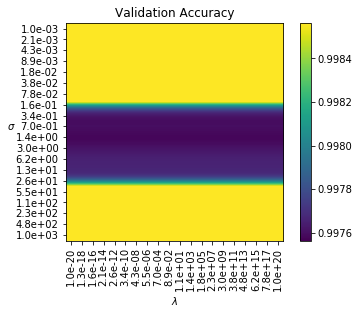

In [11]:
# initialize the parameter candidates
fig, ax = plt.subplots()

# plot the colormap
aux_score_grid = score_grid**0.001
cax = ax.imshow(aux_score_grid, interpolation='bicubic', 
                origin='upper',
                vmin = aux_score_grid.min(), vmax = aux_score_grid.min()*1.001)

# # plot the minimum values
# plt.plot(best_sigma_idx, best_lam_idx,
#          color='red', marker='+', markersize=15)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

# def format_ticks(value, tick_number):
    

fmt_sigma = ['%1.1e' % i for i in sigma_candidates.tolist()]
fmt_lam = ['%1.1e' % i for i in lam_candidates.tolist()]

ax.set_xlabel(r'$\lambda$')
ax.set_xticks(np.arange(len(fmt_lam)))
ax.set_xticklabels(fmt_lam, rotation=90)

ax.set_ylabel(r'$\sigma$', rotation=0)
ax.set_yticks(np.arange(len(fmt_sigma)))
ax.set_yticklabels(fmt_sigma)

cbar = fig.colorbar(cax)
ax.set_title('Validation Accuracy')
plt.show()

/Users/eman/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.600917952150274e-21 / 1.1102230246251565e-16
  RuntimeWarning)


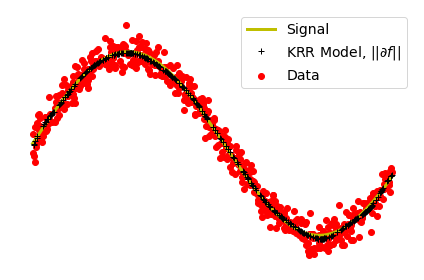

In [12]:
best_gamma = 1 / (2 * best_sigma ** 2)

# construct kernel matrices
K_train = rbf_kernel(X=x['train'], gamma=best_gamma)
K_test = rbf_kernel(X=x['train'], Y=x['test'], 
                    gamma=best_gamma)

# construct derivative
x_train = np.float64(x['train'])
x_function = np.float64(x['train'])
kernel_mat = np.float64(K_train)
temp_weights = np.float64(np.ones(x_train.shape[0])).squeeze()
best_gamma = np.float64(best_gamma)
n_derivative = 1


# Cython Implementation
derivative_cy = rbf_derivative_cy(x_train=x_train,
                           x_function=x_function,
                           kernel_mat=kernel_mat,
                           weights=temp_weights,
                           gamma=best_gamma,
                           n_derivative=n_derivative)

# slow method: solve problem
t0 = time()
alpha = scio.linalg.solve(K_train @ K_train + 
                      best_lam * derivative_cy @ derivative_cy.T, 
                      K_train.T @ y['train'])


# project the data
y_pred = (K_test.T @ alpha).squeeze()

fig, ax = plt.subplots()

# plot the signal
ax.plot(x['data'], x['signal'], color='y', linewidth=3, label='Signal')

# plot kernel model
ax.plot(x['test'], y_pred, 'k+', linewidth=3, 
        label=r'KRR Model, $||\partial{f}||$')

# plot data
ax.scatter(x['train'], y['train'], color='r', label='Data')

ax.tick_params(
    axis='both',
    which='both',
    bottom='off',
    left='off',
    top='off',
    labelbottom='off',
    labelleft='off')

# get rid of frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.legend(fontsize=14)
plt.tight_layout()

plt.show()

## KRR ($||\partial^2 f||$)

In [13]:
# parameter heuristics
mean_sigma = np.mean(pdist(x['train'], metric='euclidean'))
mean_gamma = 1 / (2 * mean_sigma ** 2)
lam = 1.0


# construct kernel matrices
K_train = rbf_kernel(X=x['train'], gamma=mean_sigma)
K_test = rbf_kernel(X=x['train'], Y=x['test'], gamma=mean_sigma)

# construct derivative
x_train = np.float64(x['train'])
x_function = np.float64(x['train'])
kernel_mat = np.float64(K_train)
temp_weights = np.float64(np.ones(x_train.shape[0])).squeeze()
mean_gamma = np.float64(mean_gamma)
n_derivative = 2

# Python Implementation
t0 = time()
derivative2 = rbf_derivative(x_train=x_train,
                               x_function=x_function,
                               kernel_mat=kernel_mat,
                               weights=temp_weights,
                               gamma=mean_gamma,
                               n_derivative=n_derivative)
t1_python = time() - t0
print('Time taken for Python: {:.4f} secs'.format(t1_python))


# Cython Implementation
t0 = time()
derivative2_cy = rbf_derivative_cy(x_train=x_train,
                               x_function=x_function,
                               kernel_mat=kernel_mat,
                               weights=temp_weights,
                               gamma=mean_gamma,
                               n_derivative=n_derivative)
t1_cython = time() - t0
print('Time taken for Cython: {:.4f} secs'.format(t1_cython))

print('\nSpeedup: x{:.2f}'.format(t1_python/t1_cython))
print('\nAll values are the same:',
      np.allclose(derivative2, derivative2_cy))
# project the data
y_pred = np.matmul(K_test.T, alpha)

Time taken for Python: 0.6451 secs
Time taken for Cython: 0.0348 secs

Speedup: x18.52

All values are the same: True


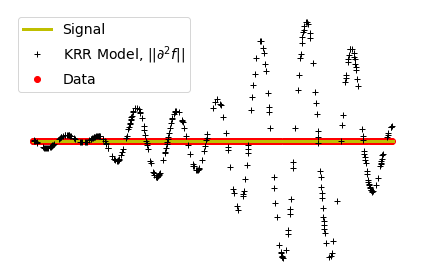

In [14]:
# print('Score Grid: {}'.format(score_grid))
fig, ax = plt.subplots()

# plot the signal
ax.plot(x['data'], x['signal'], color='y', linewidth=3, label='Signal')

# plot kernel model
ax.plot(x['test'], y_pred, 'k+', linewidth=3, label=r'KRR Model, $||\partial^2 f||$')

# plot data
ax.scatter(x['train'], y['train'], color='r', label='Data')

ax.tick_params(
    axis='both',
    which='both',
    bottom='off',
    left='off',
    top='off',
    labelbottom='off',
    labelleft='off')

# get rid of frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.legend(fontsize=14)
plt.tight_layout()

plt.show()

### With Crossvalidation

In [15]:
# initialize the parameter candidates
sigma_candidates = np.logspace(-3, 3, num=20)
lam_candidates = np.hstack((np.logspace(-20, 20, num=20)))

# initialize grid
score_grid = np.empty(shape=(len(sigma_candidates), len(lam_candidates)))

print('Shape of grid: {}'.format(score_grid.shape))
print('Number of sigmas: {}'.format(score_grid.shape[0]))
print('Number of lambdas: {}'.format(score_grid.shape[1]))
min_score = np.inf


# loop through sigma values
warnings.filterwarnings("ignore")
for (i, isigma) in enumerate(sigma_candidates):
    
    # loop through lambda values
    for (j, ilam) in enumerate(lam_candidates):
        
        igamma = 1 / (2 * isigma ** 2)

        # construct kernel matrices
        K_train = rbf_kernel(X=x['train'], gamma=igamma)
        K_test = rbf_kernel(X=x['train'], Y=x['validation'], 
                            gamma=igamma)

        # construct derivative
        x_train = np.float64(x['train'])
        x_function = np.float64(x['train'])
        kernel_mat = np.float64(K_train)
        temp_weights = np.float64(np.ones(x_train.shape[0])).squeeze()
        igamma = np.float64(igamma)
        n_derivative = 2


        # Cython Implementation
        derivative2_cy = rbf_derivative_cy(x_train=x_train,
                                   x_function=x_function,
                                   kernel_mat=kernel_mat,
                                   weights=temp_weights,
                                   gamma=igamma,
                                   n_derivative=n_derivative)

        # slow method: solve problem
        t0 = time()
        alpha = scio.linalg.solve(K_train @ K_train + 
                              lam * derivative2_cy @ derivative2_cy.T, 
                              K_train.T @ y['train'])


        # project the data
        y_pred = (K_test.T @ alpha).squeeze()
        
        # save the score
        score_grid[i, j] = mean_absolute_error(y['validation'], y_pred)
        
        # save best score
        if score_grid[i, j] < min_score:
            
            min_score = score_grid[i, j]
            best_lam_idx = j
            best_sigma_idx = i
            best_lam = ilam
            best_sigma = isigma
       
warnings.filterwarnings("default")

# normalize score grid
score_grid = score_grid

print('Minimum Score: {}'.format(min_score))
print('Best Lambda: {}'.format(best_lam))
print('Best Sigma: {}'.format(best_sigma))
print('Best Lambda Index: {}'.format(best_lam_idx))
print('Best Sigma Index: {}'.format(best_sigma_idx))

Shape of grid: (20, 20)
Number of sigmas: 20
Number of lambdas: 20
Minimum Score: 0.08384515001458846
Best Lambda: 1e-20
Best Sigma: 6.158482110660261
Best Lambda Index: 0
Best Sigma Index: 12


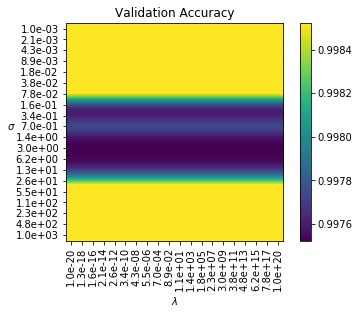

In [16]:
# initialize the parameter candidates
fig, ax = plt.subplots()

# plot the colormap
aux_score_grid = score_grid**0.001
cax = ax.imshow(aux_score_grid, interpolation='bicubic', 
                origin='upper',
                vmin = aux_score_grid.min(), vmax = aux_score_grid.min()*1.001)

# # plot the minimum values
# plt.plot(best_sigma_idx, best_lam_idx,
#          color='red', marker='+', markersize=15)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

# def format_ticks(value, tick_number):
    

fmt_sigma = ['%1.1e' % i for i in sigma_candidates.tolist()]
fmt_lam = ['%1.1e' % i for i in lam_candidates.tolist()]

ax.set_xlabel(r'$\lambda$')
ax.set_xticks(np.arange(len(fmt_lam)))
ax.set_xticklabels(fmt_lam, rotation=90)

ax.set_ylabel(r'$\sigma$', rotation=0)
ax.set_yticks(np.arange(len(fmt_sigma)))
ax.set_yticklabels(fmt_sigma)

cbar = fig.colorbar(cax)
ax.set_title('Validation Accuracy')
plt.show()       

/Users/eman/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.819505056445763e-21 / 1.1102230246251565e-16
  RuntimeWarning)


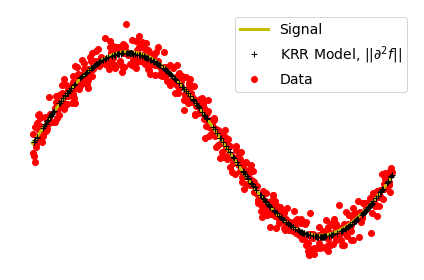

In [17]:
best_gamma = 1 / (2 * best_sigma ** 2)

# construct kernel matrices
K_train = rbf_kernel(X=x['train'], gamma=best_gamma)
K_test = rbf_kernel(X=x['train'], Y=x['test'], 
                    gamma=best_gamma)

# construct derivative
x_train = np.float64(x['train'])
x_function = np.float64(x['train'])
kernel_mat = np.float64(K_train)
temp_weights = np.float64(np.ones(x_train.shape[0])).squeeze()
best_gamma = np.float64(best_gamma)
n_derivative = 2


# Cython Implementation
derivative2_cy = rbf_derivative_cy(x_train=x_train,
                           x_function=x_function,
                           kernel_mat=kernel_mat,
                           weights=temp_weights,
                           gamma=best_gamma,
                           n_derivative=n_derivative)

# slow method: solve problem
t0 = time()
alpha = scio.linalg.solve(K_train @ K_train + 
                      best_lam * derivative2_cy @ derivative2_cy.T, 
                      K_train.T @ y['train'])


# project the data
y_pred = (K_test.T @ alpha).squeeze()

fig, ax = plt.subplots()

# plot the signal
ax.plot(x['data'], x['signal'], color='y', linewidth=3, label='Signal')

# plot kernel model
ax.plot(x['test'], y_pred, 'k+', linewidth=3, 
        label=r'KRR Model, $||\partial^2 f||$')

# plot data
ax.scatter(x['train'], y['train'], color='r', label='Data')

ax.tick_params(
    axis='both',
    which='both',
    bottom='off',
    left='off',
    top='off',
    labelbottom='off',
    labelleft='off')

# get rid of frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.legend(fontsize=14)
plt.tight_layout()

plt.show()